# Pfeffel Processing for Boris Bikes

In [9]:
import datetime

import h3 # uber geo package
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib

from tqdm.auto import tqdm

In [10]:
# sns.set_theme()
tqdm.pandas()

TODO: this needs doesn't persist in initial notebook run and has to be run again separately and charts redrawn :( - fix

In [11]:
matplotlib.rcParams['figure.figsize'] = (20, 10)

# load

load reference data for bike station locations

In [12]:
# TODO update
RAW = "./data/cleaned_data_20250820_0907.pickle"

LOCATION_REF = "./data/stations_loc.json"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle(RAW)

df.head()

,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,filename
rental_id,,,,,,,,,
9340154,412,4212,2012-01-04 00:29:00,70,"Calshot Street , King's Cross",2012-01-04 00:22:00,98,"Hampstead Road, Euston",/Users/lishanguillemot/Documents/GitHub/pfeffe...
9340229,1012,5832,2012-01-04 01:03:00,151,"Chepstow Villas, Notting Hill",2012-01-04 00:46:00,216,"Old Brompton Road, South Kensington",/Users/lishanguillemot/Documents/GitHub/pfeffe...
9340571,1003,1230,2012-01-04 00:58:00,42,"Wenlock Road , Hoxton",2012-01-04 00:41:00,23,"Red Lion Square, Holborn",/Users/lishanguillemot/Documents/GitHub/pfeffe...
9340734,894,6183,2012-01-04 01:04:00,181,"Belgrave Square, Belgravia",2012-01-04 00:49:00,201,"Dorset Square, Marylebone",/Users/lishanguillemot/Documents/GitHub/pfeffe...
9340768,1238,893,2012-01-04 00:20:00,169,"Porchester Place, Paddington",2012-01-04 00:00:00,224,"Queensway, Kensington Gardens",/Users/lishanguillemot/Documents/GitHub/pfeffe...


In [13]:
station_locations_df = pd.read_json(LOCATION_REF).T

main data, load with dask

In [14]:
# load raw data
df = pd.read_pickle(RAW)

about 100M rows

In [15]:
# num rows
len(df)

97486011

some cleaning of bad dates

In [16]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)

In [17]:
%%time
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]

# also drop entries where start date before end date
df = df[df["start_date"] < df["end_date"]]

# recalc duration
df["duration"] = df["end_date"]  - df["start_date"] 

CPU times: user 14.5 s, sys: 14.2 s, total: 28.7 s
Wall time: 34.9 s


we've lost a few!

In [18]:
len(df)

96950930

# Basic stats

In [19]:
%%time
# how many bikes
df["bike_id"].nunique()

CPU times: user 2.13 s, sys: 763 ms, total: 2.89 s
Wall time: 3.14 s


21149

In [20]:
bike_groups = df.groupby("bike_id")

In [21]:
%%time
# bike with the most trips
group_counts = bike_groups.count()["filename"] # pick abritrary column (without nulls) to get counts
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(f"""
bike with most trips: {b_id}
did {n_trips} trips
""")


bike with most trips: 8875
did 10007 trips

CPU times: user 7.98 s, sys: 892 ms, total: 8.87 s
Wall time: 9.03 s


In [22]:
%%time
# bike with the longest trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]


print(f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} seconds
""")


bike with longest sum duration of trips: 2143
total of 215 days 05:46:00 seconds

CPU times: user 460 ms, sys: 102 ms, total: 562 ms
Wall time: 675 ms


how long are trips? (excluding outliers)

<AxesSubplot:>

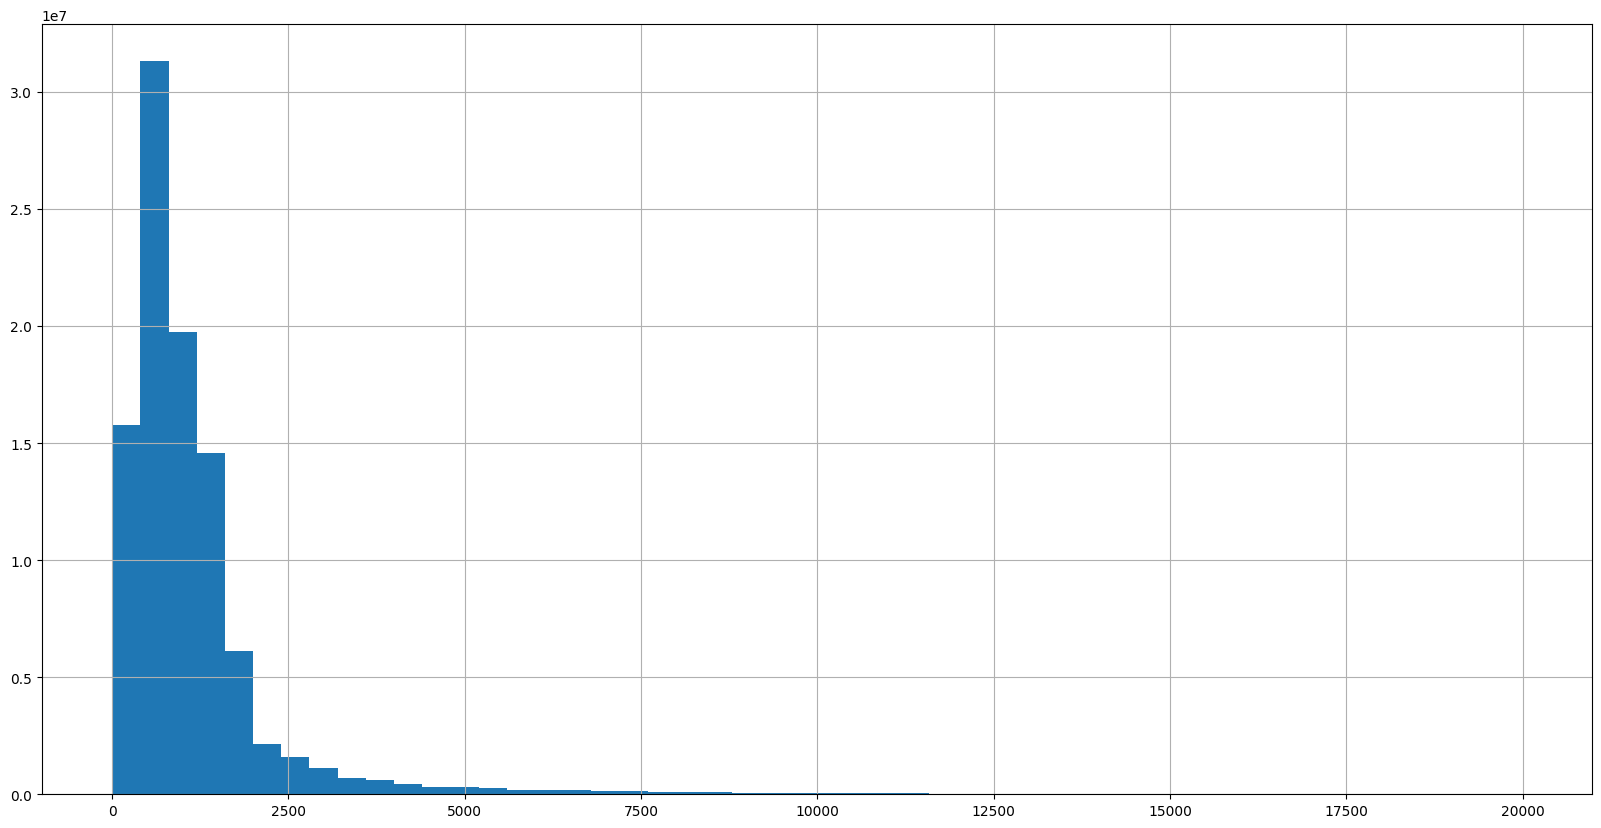

In [23]:
df[df["duration"].dt.seconds < 20000]["duration"].dt.seconds.hist(bins=50)

## Long-lived bikes

In [24]:
%%time
trips_per_bike = bike_groups["filename"].count()

CPU times: user 2.21 s, sys: 230 ms, total: 2.44 s
Wall time: 2.03 s


In [25]:
%%time
# relies on time ordering of df via rental_id
bike_start = bike_groups["start_date"].first()

CPU times: user 136 ms, sys: 96.9 ms, total: 233 ms
Wall time: 233 ms


In [26]:
%%time
# relies on time ordering of df via rental_id
bike_end = bike_groups["end_date"].last()

CPU times: user 203 ms, sys: 120 ms, total: 323 ms
Wall time: 324 ms


In [27]:
%%time 
bike_lifetime = bike_end - bike_start

CPU times: user 766 μs, sys: 1.2 ms, total: 1.96 ms
Wall time: 1.45 ms


how long is the lifetime of a bike? (in days)

<AxesSubplot:>

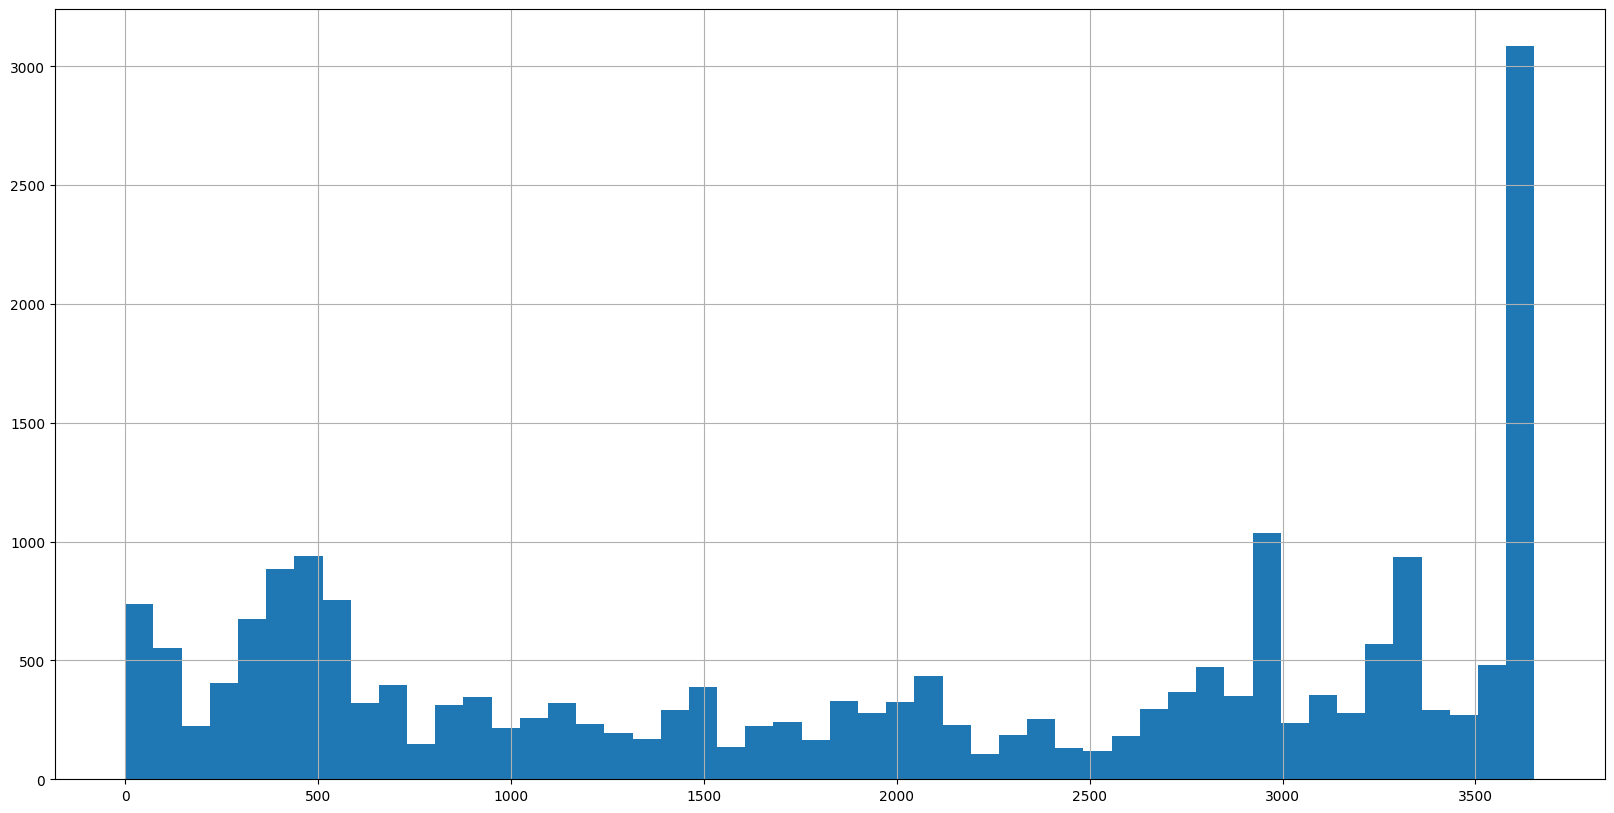

In [28]:
bike_lifetime.dt.days.hist(bins=50)

In [29]:
%%time
duration_sums = bike_groups["duration"].sum()

CPU times: user 912 ms, sys: 198 ms, total: 1.11 s
Wall time: 674 ms


In [30]:
%%time
bike_utilisation = duration_sums / bike_lifetime

CPU times: user 317 μs, sys: 173 μs, total: 490 μs
Wall time: 643 μs


what is the average utilisation of a bike? (total ride duration / lifetime)

this is the mean of the per bike utilisation. I.e. each bike's usage divided by it's total lifetime.

In [31]:
bike_utilisation.mean()

0.04071526926308066

<AxesSubplot:>

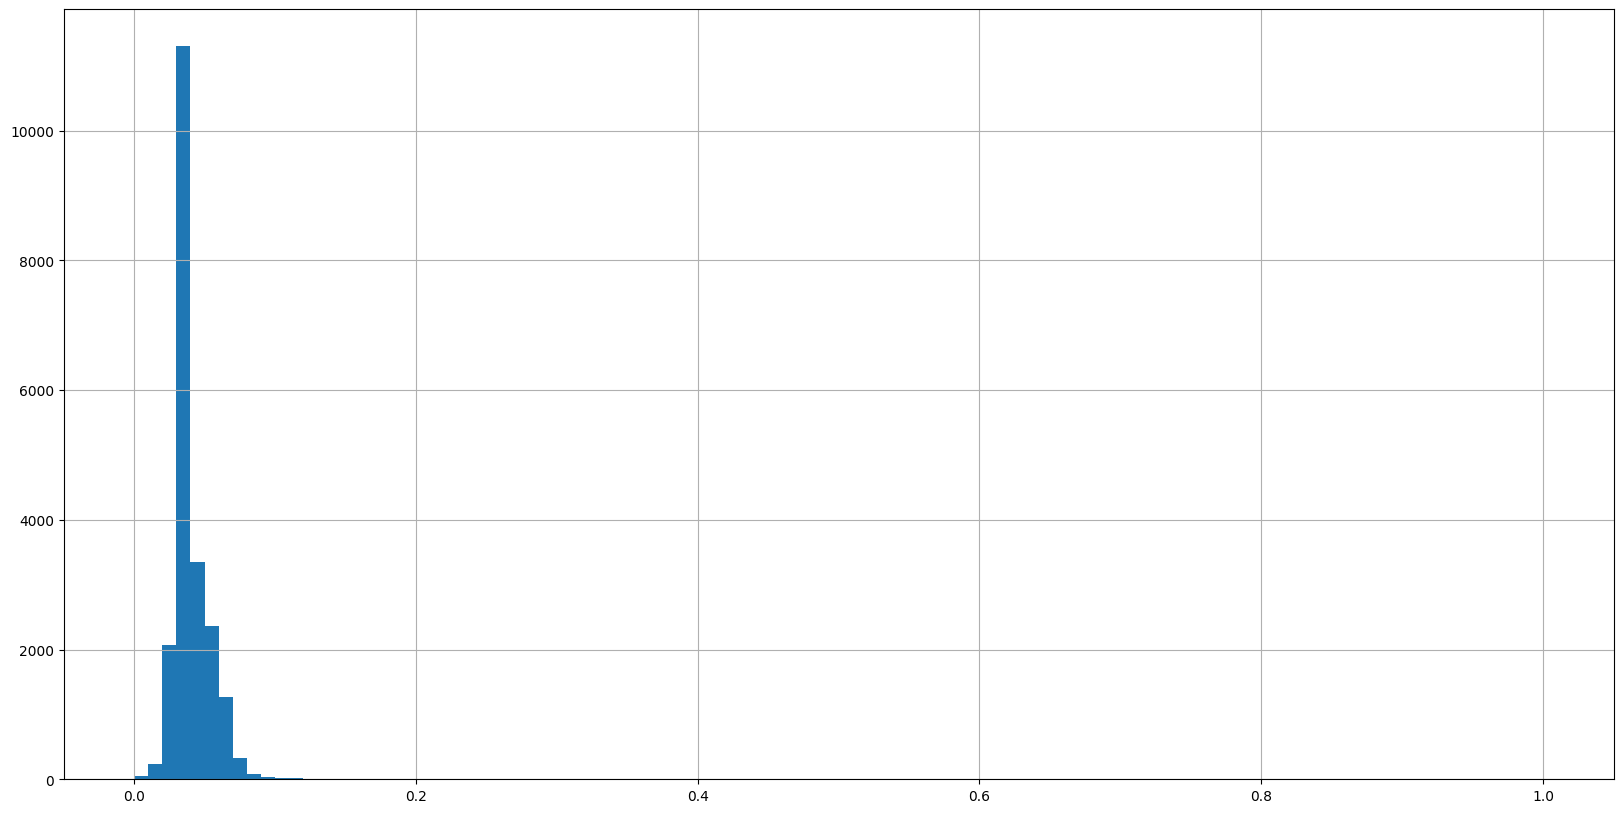

In [32]:
bike_utilisation.hist(bins=100)

### per month

- how many bikes are "alive" by month?

- how many stations are "alive" by month?

- what is bike utilisation by month? 

our utilisation measure here will be slightly different to previous figure. Previously we looked at per bike utilisation and averaged this. Now, we're looking at sum of use over the entire fleet and dividing this by the max possible usage per month (24/7 riding).

In [33]:
# don't want to incude first and last months as may be incompelte, use in filter later
incomplete_months = df["start_date"].iloc[[0, -1]].dt.to_period("M")


# create a complete monthly index that covers ALL months in period 
complete_monthly_index = pd.date_range(start=df["start_date"].iloc[0], end=df["end_date"].iloc[-1], freq="M").to_period("M")
# remove incomplete months
complete_monthly_index = complete_monthly_index.delete(complete_monthly_index.isin(incomplete_months))

In [34]:
# TODO should stations count as allive for next month rather than current?
def calc_alive_per_month(starts: pd.Series, ends: pd.Series, incomplete_months: pd.Series, complete_monthly_index: pd.PeriodIndex):
    starts_per_month = starts.dt.to_period("M").value_counts()
    ends_per_month = ends.dt.to_period("M").value_counts()

    counts_df = complete_monthly_index.to_frame(name="foo").join(starts_per_month).join(ends_per_month).sort_index().fillna(0)
    # ending items should only be counted at the start of next month, so shift
    counts_df["end_date"] = counts_df["end_date"].shift(fill_value=0)

    alive_per_month = counts_df["start_date"].cumsum() - counts_df["end_date"].cumsum()
    
    return alive_per_month[~alive_per_month.index.isin(incomplete_months)]

In [35]:
%%time

alive_bikes_per_month = calc_alive_per_month(starts=bike_start, ends=bike_end, incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

CPU times: user 44.1 ms, sys: 2.85 ms, total: 46.9 ms
Wall time: 21.3 ms


In [36]:
%%time
duration_sums_per_month = df[["duration"]].groupby(df["start_date"].dt.to_period("M"))["duration"].sum()

duration_sums_per_month = duration_sums_per_month.to_frame()
duration_sums_per_month["max_possible_duration"] = duration_sums_per_month.index.map(lambda x: x.end_time - x.start_time)

utilisation_per_month = duration_sums_per_month["duration"] / duration_sums_per_month["max_possible_duration"] / alive_bikes_per_month

# remove incomplelte months
utilisation_per_month = utilisation_per_month[~utilisation_per_month.index.isin(incomplete_months)]

CPU times: user 1.87 s, sys: 385 ms, total: 2.26 s
Wall time: 2.15 s


In [37]:
%%time

station_groups = df.groupby("start_station_id")

# relies on time ordering of df via rental_id
station_start = station_groups["start_date"].first()
station_end = station_groups["end_date"].last()

CPU times: user 504 ms, sys: 256 ms, total: 760 ms
Wall time: 770 ms


In [38]:
alive_stations_per_month = calc_alive_per_month(starts=station_start, ends=station_end,
                                                incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

In [39]:
# forward fill gaps
stats_df = complete_monthly_index.to_frame(name="date")\
    .join(alive_bikes_per_month.rename("alive_bikes"))\
    .join(alive_stations_per_month.rename("alive_stations"))\
    .join(utilisation_per_month.rename("utilisation"))\
    .fillna(method="ffill") 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

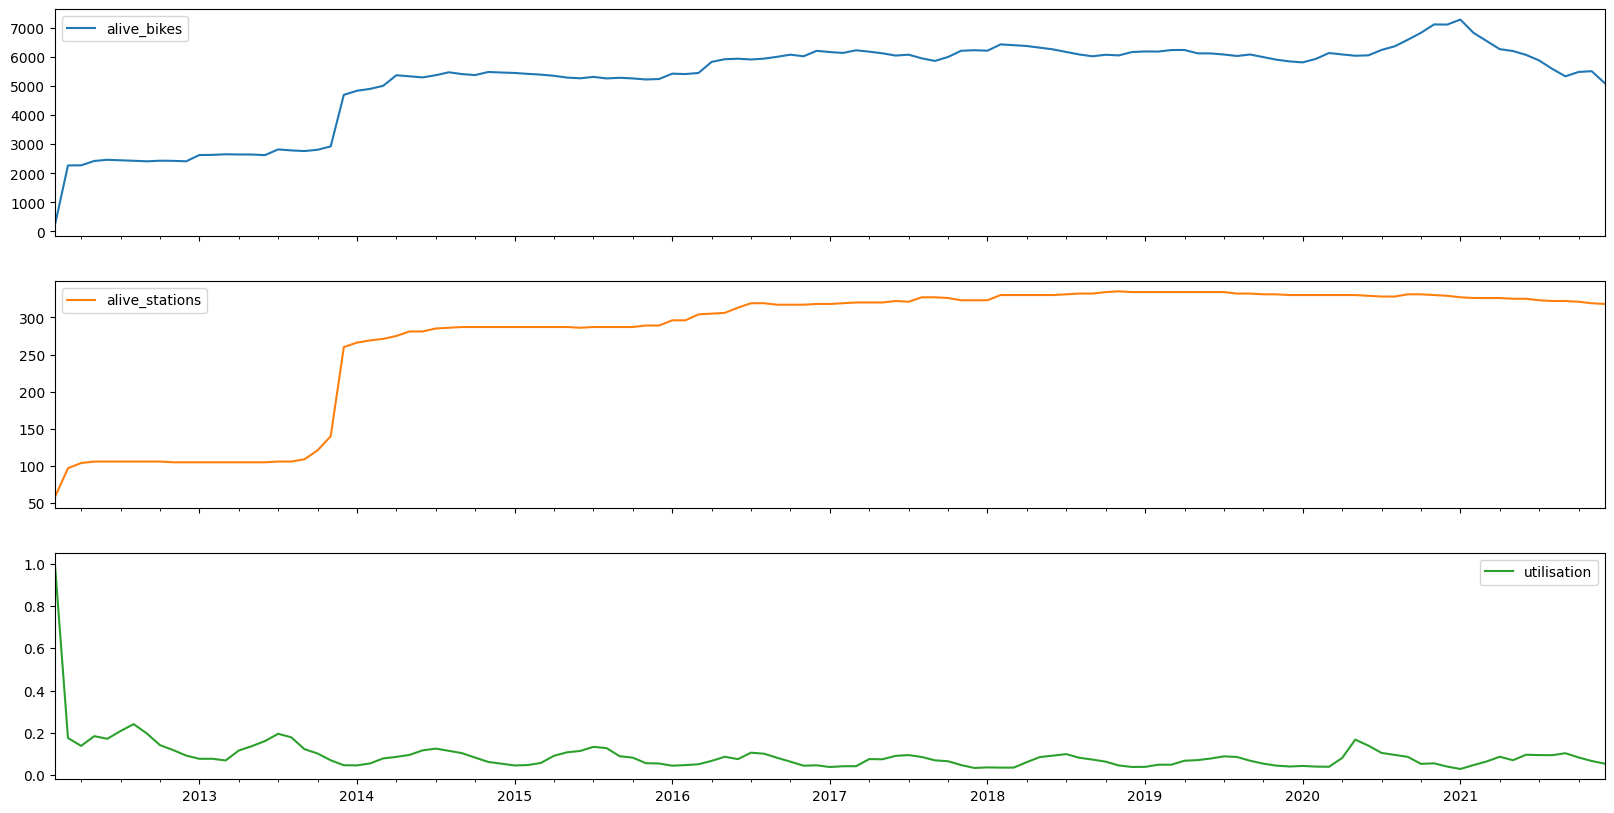

In [40]:
stats_df.plot(subplots=True)

Taking a look at utilisation without the first month throwing us off.

Recall, this is over the fleet rather than a measure per bike.

<AxesSubplot:>

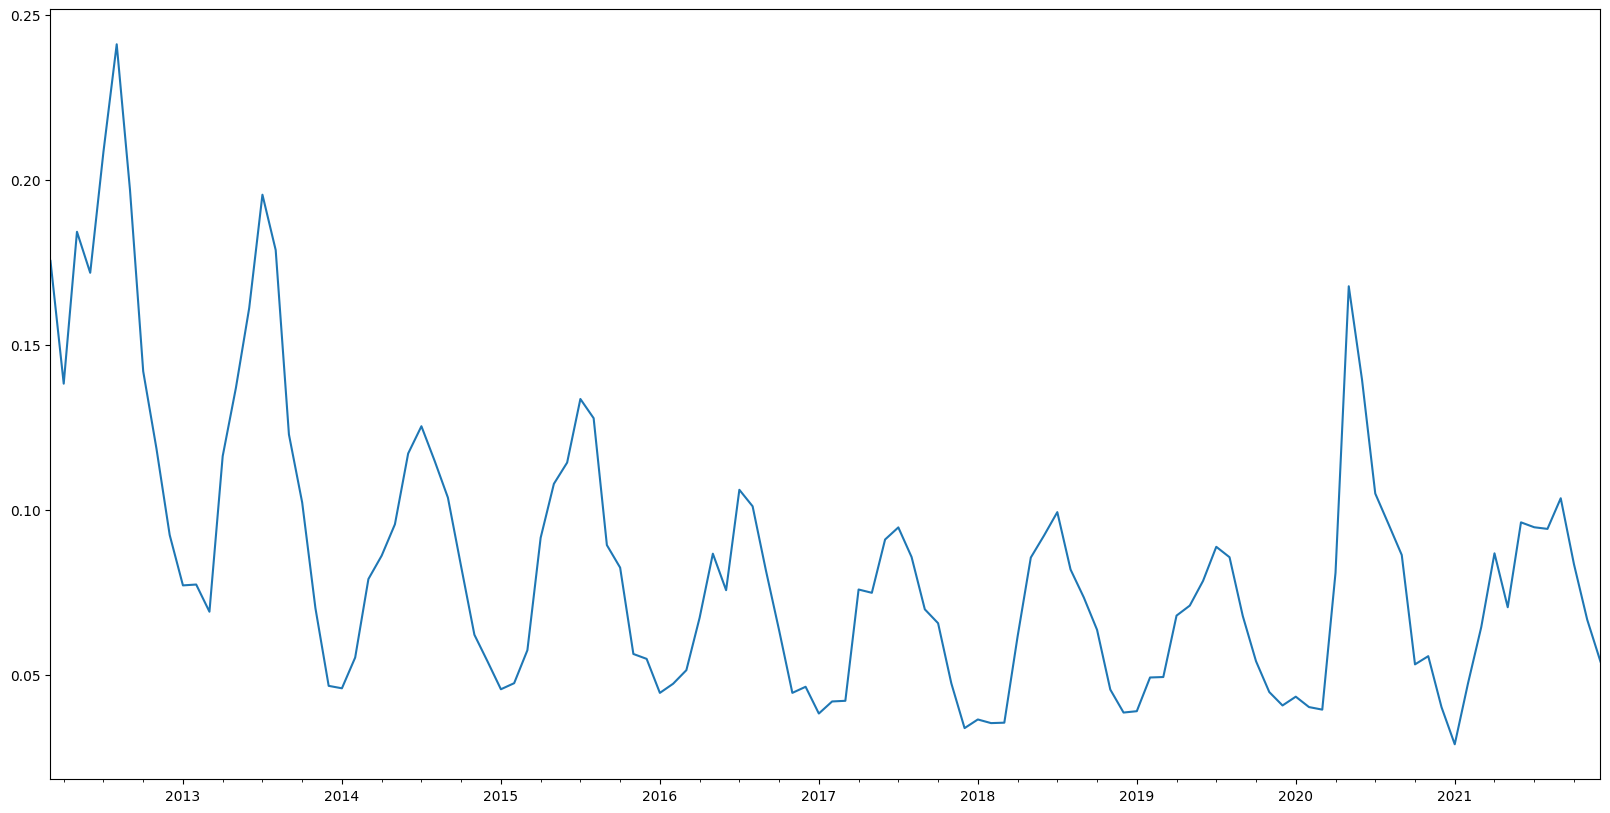

In [41]:
stats_df["utilisation"][1:].plot()

whats happening to the number of active stations in 2012?

In [42]:
stats_df_2012 = stats_df[(stats_df.index.to_timestamp() >= datetime.datetime(year=2012, month=1, day=1)) &
        (stats_df.index.to_timestamp() < datetime.datetime(year=2013, month=1, day=1))]


# increase in April and Decrease in Jul

may_2012_new_stations = station_start[(station_start >= datetime.datetime(year=2012, month=5, day=1)) &
             (station_start < datetime.datetime(year=2012, month=6, day=1))]

# note these will actually be last used in prev month i.e. june
jul_2012_removed_stations = station_end[(station_end >= datetime.datetime(year=2012, month=6, day=1)) &
             (station_end < datetime.datetime(year=2012, month=7, day=1))]

len(may_2012_new_stations), len(jul_2012_removed_stations)

(2, 0)

## Station Areas

In [43]:
%%time
all_stations = pd.concat([
    df[["start_station_id", "start_station_name"]].rename(columns={"start_station_id": "id", "start_station_name": "name"}),
    df[["end_station_id", "end_station_name"]].rename(columns={"end_station_id": "id", "end_station_name": "name"})
]).convert_dtypes().set_index(keys="id").drop_duplicates().dropna()

# filter to str names only
all_stations = all_stations[all_stations["name"].map(lambda x: isinstance(x, str))]

CPU times: user 17.6 s, sys: 10 s, total: 27.6 s
Wall time: 32.5 s


have a look at station name pieces, is the part after the comma an "area"?

In [44]:
station_name_pieces = all_stations["name"].progress_map(lambda name: name.split(","))

station_single_pieces = station_name_pieces[station_name_pieces.progress_map(len) <= 1]
station_areas =  station_name_pieces.progress_map(lambda name_pieces: name_pieces[1] if len(name_pieces) > 1 else None).dropna()

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

  0%|          | 0/940 [00:00<?, ?it/s]

what are the items with only one "piece" i.e. no comma

In [45]:
station_single_pieces.head()

id
302    [Fore Street Avenue: Guildhall]
174                           [Strand]
271                       [London Zoo]
137         [Bourne Street: Belgravia]
198                        [tabletop1]
Name: name, dtype: object

In [46]:
station_areas.value_counts()

 Marylebone     27
 Battersea      26
 Holborn        20
 Fulham         18
 Mayfair        18
                ..
 St Pauls        1
 Haggerston      1
 Bangla Town     1
 St Lukes        1
 Clapham         1
Name: name, Length: 133, dtype: int64

# chains

A "chain" is a sequence of trips for a given bike, where the start location matches the previous end location.

Run for some subset only. Try long lived bikes

In [47]:
top_ten_lived_bike_ids = bike_lifetime.sort_values()[-10:].index.values

In [48]:
top_ten_bike_subset = df[df["bike_id"].isin(top_ten_lived_bike_ids)].copy()

In [49]:
# NOTE - how to handle workshops?
# what if workshop is start ?
# what if workshop is end ?
def add_chains(bike_id: int, bike_group: pd.DataFrame, df: pd.DataFrame) -> None:
    """ note: adds to dataframe as side effect """

    # note fillna for end station to allow for comparison to NA
    breaks = bike_group[bike_group["start_station_id"] != bike_group.shift()["end_station_id"].fillna(-1)]
    break_indices = breaks.index.values

    chains = list()
    for i, (start, end) in enumerate(zip([None, *break_indices], [*break_indices, None])):
        chain = bike_group.loc[start:end]
        chain_id = f"{bike_id}_{i}"
        chains.append(pd.Series(chain_id, index=chain.index))
    return pd.concat(chains)

In [50]:
chains = list()
for k, g in tqdm(top_ten_bike_subset.groupby("bike_id")):
    g = bike_groups.get_group(k)
    chains.append(add_chains(bike_id=k, bike_group=g, df=df))

  0%|          | 0/10 [00:00<?, ?it/s]

In [51]:
top_ten_bike_subset = top_ten_bike_subset.join(pd.concat(chains).rename("chain_id"))

In [52]:
top_ten_bike_subset.to_pickle("top_ten_bikes.pickle")